In [1]:
#Data manipulation and preprocessing 
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
#Data exploration
from sklearn.feature_selection import chi2
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt
#Data balancing
from imblearn.over_sampling import SMOTE
#Modelling
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
#Model Evaluation
from sklearn.metrics import ConfusionMatrixDisplay,confusion_matrix,classification_report,accuracy_score,roc_curve
import warnings
warnings.filterwarnings("ignore")

C:\Users\user\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\user\anaconda3\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
C:\Users\user\anaconda3\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
C:\Users\user\anaconda3\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"
C:\Users\user\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### Data preprocessing

In [122]:
data = pd.read_csv("urinalysis_tests.csv")#importing the dataset
data.head()

,Unnamed: 0,Age,Gender,Color,Transparency,Glucose,Protein,pH,Specific Gravity,WBC,RBC,Epithelial Cells,Mucous Threads,Amorphous Urates,Bacteria,Diagnosis
0,0,76.0,FEMALE,LIGHT YELLOW,CLEAR,NEGATIVE,NEGATIVE,5.0,1.010,1-3,0-2,OCCASIONAL,RARE,NONE SEEN,OCCASIONAL,NEGATIVE
1,1,9.0,MALE,DARK YELLOW,SLIGHTLY HAZY,NEGATIVE,1+,5.0,1.030,1-3,0-2,RARE,FEW,FEW,MODERATE,NEGATIVE
2,2,12.0,MALE,LIGHT YELLOW,SLIGHTLY HAZY,NEGATIVE,TRACE,5.0,1.030,0-3,0-2,RARE,FEW,MODERATE,RARE,NEGATIVE
3,3,77.0,MALE,BROWN,CLOUDY,NEGATIVE,1+,6.0,1.020,5-8,LOADED,RARE,RARE,NONE SEEN,FEW,NEGATIVE
4,4,29.0,FEMALE,YELLOW,HAZY,NEGATIVE,TRACE,6.0,1.025,1-4,0-2,RARE,RARE,NONE SEEN,FEW,NEGATIVE


In [123]:
data.drop(columns = "Unnamed: 0", axis = 1,inplace = True)#removing the unnamed column
data.head()

,Age,Gender,Color,Transparency,Glucose,Protein,pH,Specific Gravity,WBC,RBC,Epithelial Cells,Mucous Threads,Amorphous Urates,Bacteria,Diagnosis
0,76.0,FEMALE,LIGHT YELLOW,CLEAR,NEGATIVE,NEGATIVE,5.0,1.010,1-3,0-2,OCCASIONAL,RARE,NONE SEEN,OCCASIONAL,NEGATIVE
1,9.0,MALE,DARK YELLOW,SLIGHTLY HAZY,NEGATIVE,1+,5.0,1.030,1-3,0-2,RARE,FEW,FEW,MODERATE,NEGATIVE
2,12.0,MALE,LIGHT YELLOW,SLIGHTLY HAZY,NEGATIVE,TRACE,5.0,1.030,0-3,0-2,RARE,FEW,MODERATE,RARE,NEGATIVE
3,77.0,MALE,BROWN,CLOUDY,NEGATIVE,1+,6.0,1.020,5-8,LOADED,RARE,RARE,NONE SEEN,FEW,NEGATIVE
4,29.0,FEMALE,YELLOW,HAZY,NEGATIVE,TRACE,6.0,1.025,1-4,0-2,RARE,RARE,NONE SEEN,FEW,NEGATIVE


In [124]:
data.shape #size of the dataset

(1436, 15)

In [125]:
data['Diagnosis'].value_counts() #values in the diagnosis

NEGATIVE    1355
POSITIVE      81
Name: Diagnosis, dtype: int64

Text(0.5, 1.0, 'Negative versus positive diagnosis')

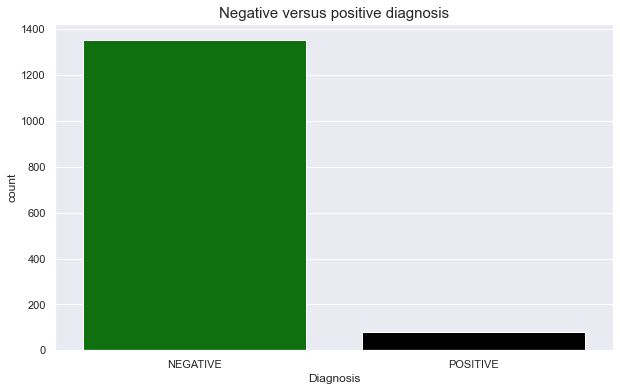

In [126]:
#Negative and positive diagnosis
plt.figure(figsize = (10,6))
sns.countplot(data['Diagnosis'], palette=['green', 'black'])
plt.title('Negative versus positive diagnosis',fontdict = {'size':15})

Text(0.5, 1.0, 'Percentage of female UTI patients among the female population')

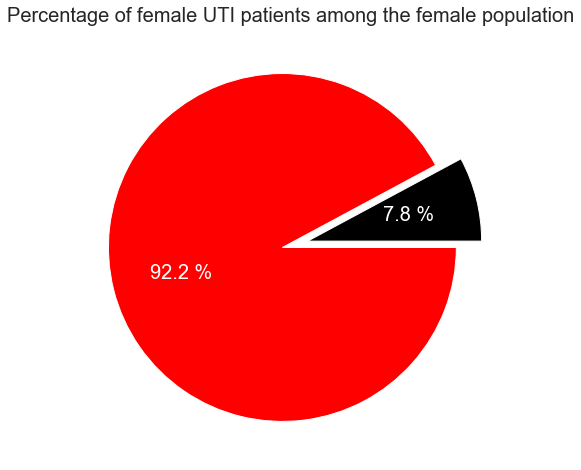

In [129]:
positive_diag = data[data['Diagnosis']=="POSITIVE"] #positive diagnosis subset
#percentage of female uti patients among the female population
perc_fem = len(positive_diag[positive_diag["Gender"]=='FEMALE'])/len(data[data["Gender"]=='FEMALE'])
plt.figure(figsize = (8,8)) #size of the pie chart
plt.pie([perc_fem,1-perc_fem],
        explode =[0.1,0.05],
        colors = ['black','red'],
       autopct = "%2.1f %%",
        textprops={"color":"white",
                   "size" : 20}
       )#pie plot showing results
plt.title("Percentage of female UTI patients among the female population",
         fontdict = {"size":20}) #title of the chart and its size

## Data Preprocessing

In [131]:
#Missing data analysis
data.isnull().sum()

Age                 0
Gender              0
Color               1
Transparency        0
Glucose             0
Protein             0
pH                  0
Specific Gravity    0
WBC                 0
RBC                 0
Epithelial Cells    0
Mucous Threads      0
Amorphous Urates    0
Bacteria            0
Diagnosis           0
dtype: int64

In [86]:
#Drop missing data rows
data.dropna(inplace = True)
data.isnull().sum()

Age                 0
Gender              0
Color               0
Transparency        0
Glucose             0
Protein             0
pH                  0
Specific Gravity    0
WBC                 0
RBC                 0
Epithelial Cells    0
Mucous Threads      0
Amorphous Urates    0
Bacteria            0
Diagnosis           0
dtype: int64

In [132]:
#convert categorical data to numerical data
cat_data = data[['Gender', 'Color', 'Transparency', 'Glucose', 'Protein', 'pH',
       'Specific Gravity', 'WBC', 'RBC', 'Epithelial Cells', 'Mucous Threads',
       'Amorphous Urates', 'Bacteria', 'Diagnosis']]
LB = LabelEncoder()
cat_data = cat_data.apply(LB.fit_transform)

In [68]:
#Chi-square for correlation in the categorical data
correlation = pd.DataFrame(data=[(0 for i in range(len(cat_data.columns))) for i in range(len(cat_data.columns))], 
                         columns=list(cat_data.columns))
correlation.set_index(pd.Index(list(cat_data.columns)), inplace = True)

# Finding p_value for all columns and putting them in the resultant matrix
for i in list(cat_data.columns):
    for j in list(cat_data.columns):
        if i != j:
            chi2_val, p_val = chi2(np.array(cat_data[i].astype("float64")).reshape(-1, 1),
                                   np.array(cat_data[j].astype("float64")).reshape(-1, 1))
            correlation.loc[i,j] = p_val


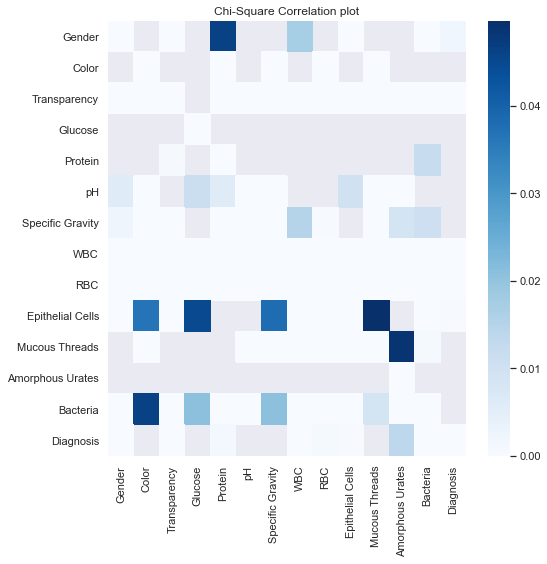

In [77]:
# Plotting a heatmap
plt.figure(figsize=(8,8))
sns.heatmap(correlation[correlation<0.05], cmap='Blues')
plt.title('Chi-Square Correlation plot')
plt.show()

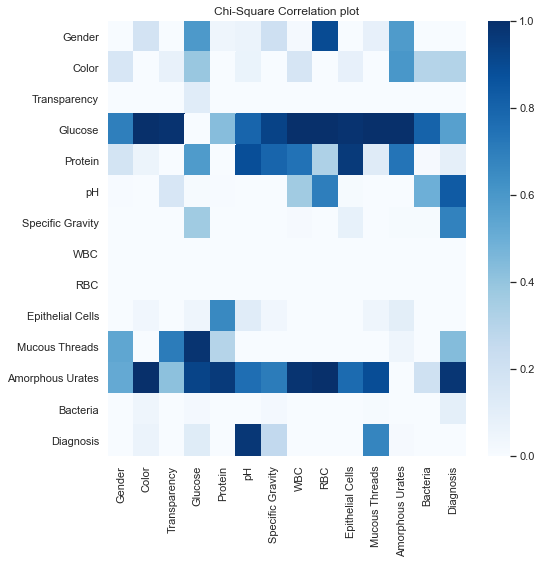

In [78]:
# Plotting a heatmap
plt.figure(figsize=(8,8))
sns.heatmap(correlation, cmap='Blues')
plt.title('Chi-Square Correlation plot')
plt.show()

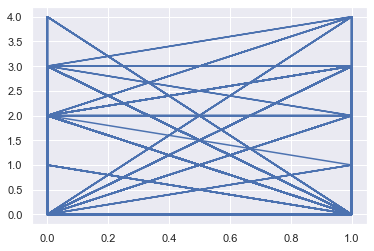

In [85]:
plt.plot(cat_data["Gender"],cat_data["Transparency"])

In [76]:
correlation[correlation<0.05]

,Gender,Color,Transparency,Glucose,Protein,pH,Specific Gravity,WBC,RBC,Epithelial Cells,Mucous Threads,Amorphous Urates,Bacteria,Diagnosis
Gender,0.000000e+00,NaN,1.119795e-08,NaN,4.629961e-02,NaN,NaN,1.746270e-02,NaN,2.078380e-53,NaN,NaN,2.307293e-19,1.756571e-03
Color,NaN,0.000000e+00,NaN,NaN,4.517818e-09,NaN,3.541703e-15,NaN,2.265114e-05,NaN,1.514538e-07,NaN,NaN,NaN
Transparency,1.721145e-28,1.836706e-09,0.000000e+00,NaN,8.896798e-41,4.253628e-17,9.901998e-13,3.220215e-185,2.290290e-60,1.905175e-80,1.394869e-11,2.724597e-65,9.342825e-158,4.929363e-42
Glucose,NaN,NaN,NaN,0.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Protein,NaN,NaN,6.897045e-04,NaN,0.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.200661e-02,NaN
pH,6.166975e-03,5.855221e-06,NaN,1.130427e-02,6.126899e-03,0.000000e+00,6.548566e-34,NaN,NaN,1.009407e-02,2.464584e-09,8.811753e-07,NaN,NaN
Specific Gravity,2.201440e-03,5.668978e-106,3.899368e-06,NaN,1.746788e-72,3.317293e-55,0.000000e+00,1.508073e-02,2.126967e-04,NaN,1.266678e-76,9.003773e-03,1.069589e-02,NaN
WBC,0.000000e+00,1.543715e-91,0.000000e+00,3.584384e-50,0.000000e+00,3.324294e-67,1.653929e-25,0.000000e+00,0.000000e+00,0.000000e+00,1.625691e-48,5.774656e-170,0.000000e+00,6.923807e-221
RBC,3.849270e-08,0.000000e+00,4.814018e-300,1.110650e-63,0.000000e+00,3.647730e-16,6.181215e-116,0.000000e+00,0.000000e+00,5.777024e-60,1.383165e-13,1.850988e-13,1.105271e-83,9.814713e-05
Epithelial Cells,9.643030e-93,3.665344e-02,1.644448e-19,4.487884e-02,NaN,NaN,3.787233e-02,1.066081e-34,8.504153e-07,0.000000e+00,4.971890e-02,NaN,1.665997e-40,3.408743e-04


In [65]:
data.columns

Index(['Age', 'Gender', 'Color', 'Transparency', 'Glucose', 'Protein', 'pH',
       'Specific Gravity', 'WBC', 'RBC', 'Epithelial Cells', 'Mucous Threads',
       'Amorphous Urates', 'Bacteria', 'Diagnosis'],
      dtype='object')

In [87]:
for col in cat_data.columns: #categorical data and what each label encoded represents
    print(data[col].unique())
    print(cat_data[col].unique())

['FEMALE' 'MALE']
[0 1]
['LIGHT YELLOW' 'DARK YELLOW' 'BROWN' 'YELLOW' 'AMBER' 'STRAW' 'RED'
 'REDDISH' 'REDDISH YELLOW' 'LIGHT RED']
[ 4  2  1  9  0  8  5  6  7  3 10]
['CLEAR' 'SLIGHTLY HAZY' 'CLOUDY' 'HAZY' 'TURBID']
[0 3 1 2 4]
['NEGATIVE' '3+' '1+' 'TRACE' '4+' '2+']
[4 2 0 5 3 1]
['NEGATIVE' '1+' 'TRACE' '2+' '3+']
[3 0 4 1 2]
[5.  6.  7.  7.5 6.5 8. ]
[0 1 3 4 2 5]
[1.01  1.03  1.02  1.025 1.005 1.015]
[1 5 3 4 0 2]
['1-3' '0-3' '5-8' '1-4' '3-5' '70-75' '0-2' '1-2' '2-4' '6-8' '8-10'
 '10-12' '0-1' '4-6' '20-25' '25-30' '18-25' '3-6' 'LOADED' '28-30' '5-7'
 '12-15' '15-17' '30-35' '8-12' '2-3' '35-40' '50-55' '11-15' '48-55'
 '45-50' '12-14' '14-16' '17-20' '55-58' '9-11' '>50' '15-20' '20-22'
 '18-20' '7-9' 'TNTC' '2-5' '34-36' '30-32' '23-25' '5-10' '9-15' '13-15'
 '4-8' '11-14' '10-16' '7-15' '7-8' '0-4' '15-22' '15-21' '>100' '7-10'
 '15-28' '1-5' '4-5' '2-7' '3-7' '10-15' '4-7' '79-85' '28-35' '3-10'
 '5-6' '3-4' '15-18' '4-10' '10-18' '8-11']
[ 5  2 56  6 39 64  1  4 28 5

In [140]:
#Feature selection and data splitting
x = pd.concat([cat_data,data['Age']],axis = 1)
y = cat_data['Diagnosis']
len(y)

1436

In [141]:
x.head()

,Gender,Color,Transparency,Glucose,Protein,pH,Specific Gravity,WBC,RBC,Epithelial Cells,Mucous Threads,Amorphous Urates,Bacteria,Diagnosis,Age
0,0,4,0,4,3,0,1,5,2,4,5,2,3,0,76.0
1,1,2,3,4,0,0,5,5,2,6,0,0,2,0,9.0
2,1,4,3,4,4,0,5,2,2,6,0,1,5,0,12.0
3,1,1,1,4,0,1,3,56,51,6,5,2,0,0,77.0
4,0,9,2,4,4,1,4,6,2,6,5,2,0,0,29.0


In [112]:
cat_data.isnull().sum()

Gender              0
Color               0
Transparency        0
Glucose             0
Protein             0
pH                  0
Specific Gravity    0
WBC                 0
RBC                 0
Epithelial Cells    0
Mucous Threads      0
Amorphous Urates    0
Bacteria            0
Diagnosis           0
dtype: int64

In [146]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size = 0.3, random_state = 40)
print(len(x_train))
print(len(x_test))

1005
431


In [151]:
#Model training
knn = KNeighborsClassifier()
knn.fit(x_train,y_train)
knn_pred = knn.predict(x_test)
accuracy_score(y_test,knn_pred)

0.9559164733178654

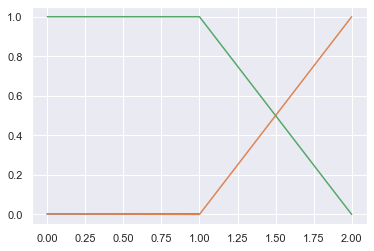

In [153]:
plt.plot(roc_curve(y_test,knn_pred))